### IMPORT MODULES

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from joblib import dump, load 
from scipy.sparse import save_npz, load_npz 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import pandas as pd
import string
import os
import re

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

import numpy as np

cleantweets_df = pd.read_csv("../data/processed_global_data_tweets.csv")
cleantweets_df.head()

,created_at,source,full_text,polarity,subjectivity,sentiment,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-08-07 22:31:20+00:00,Twitter for Android,RT @i_ameztoy Extra random image I Lets focus ...,-1.250000e-01,0.190625,negative,en,15760,2,i_ameztoy,20497,2621,not_found,City++++,i_ameztoy++++,not_known
1,2022-08-07 22:31:16+00:00,Twitter for Android,RT @IndoPac_Info #Chinas media explains the mi...,-1.000000e-01,0.100000,negative,en,6967,201,ZIisq,65,272,not_found,China++++Taiwan++++,IndoPac_Info++++,not_known
2,2022-08-07 22:31:07+00:00,Twitter for Android,China even cut off communication they dont anw...,0.000000e+00,0.000000,neutral,en,2166,0,Fin21Free,85,392,not_found,XiJinping++++,ZelenskyyUa++++,Netherlands
3,2022-08-07 22:31:06+00:00,Twitter for Android,Putin to #XiJinping I told you my friend Taiwa...,1.000000e-01,0.350000,positive,en,2166,0,Fin21Free,85,392,not_found,XiJinping++++,NaN,Netherlands
4,2022-08-07 22:31:04+00:00,Twitter for iPhone,RT @ChinaUncensored I’m sorry I thought Taiwan...,-6.938894e-18,0.556250,negative,en,17247,381,VizziniDolores,910,2608,not_found,NaN,ChinaUncensored++++,Ayent Schweiz


### TOPIC MODELING

In [2]:
tweets_df = cleantweets_df
tweets_df.head()

,created_at,source,full_text,polarity,subjectivity,sentiment,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-08-07 22:31:20+00:00,Twitter for Android,RT @i_ameztoy Extra random image I Lets focus ...,-1.250000e-01,0.190625,negative,en,15760,2,i_ameztoy,20497,2621,not_found,City++++,i_ameztoy++++,not_known
1,2022-08-07 22:31:16+00:00,Twitter for Android,RT @IndoPac_Info #Chinas media explains the mi...,-1.000000e-01,0.100000,negative,en,6967,201,ZIisq,65,272,not_found,China++++Taiwan++++,IndoPac_Info++++,not_known
2,2022-08-07 22:31:07+00:00,Twitter for Android,China even cut off communication they dont anw...,0.000000e+00,0.000000,neutral,en,2166,0,Fin21Free,85,392,not_found,XiJinping++++,ZelenskyyUa++++,Netherlands
3,2022-08-07 22:31:06+00:00,Twitter for Android,Putin to #XiJinping I told you my friend Taiwa...,1.000000e-01,0.350000,positive,en,2166,0,Fin21Free,85,392,not_found,XiJinping++++,NaN,Netherlands
4,2022-08-07 22:31:04+00:00,Twitter for iPhone,RT @ChinaUncensored I’m sorry I thought Taiwan...,-6.938894e-18,0.556250,negative,en,17247,381,VizziniDolores,910,2608,not_found,NaN,ChinaUncensored++++,Ayent Schweiz


In [3]:
tweets_df['full_text'] = tweets_df['full_text'].astype(str) 
# Casting to type str 
tweets_df['full_text'] = tweets_df['full_text'].apply(lambda x: x.lower())
# Converting rows under the column 'full_text' to lowercase
tweets_df['full_text'] = tweets_df['full_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation))) 


#### Converting tweets to list of words for feature engineering

In [4]:
sentence_list = [tweet for tweet in tweets_df['full_text']]
word_list = [sent.split() for sent in sentence_list]

#### Creating dictionary which contains Id and word

In [5]:

word_to_id = corpora.Dictionary(word_list)
corpus= [word_to_id.doc2bow(tweet) for tweet in word_list]

#### Build LDA mode

In [6]:
lda_model = gensim.models.ldamodel.LdaModel(corpus,id2word=word_to_id,
    num_topics=5,random_state=100,update_every=1,chunksize=100,passes=10,
    alpha='auto',per_word_topics=True)

#### Showing topics

In [7]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('the', 0.04893881),
   ('rt', 0.03185435),
   ('taiwan', 0.026689447),
   ('to', 0.024368063),
   ('for', 0.021703126),
   ('a', 0.015642472),
   ('on', 0.015002597),
   ('what', 0.0148037765),
   ('of', 0.014781461),
   ('and', 0.014759566)]),
 (1,
  [('rt', 0.041287053),
   ('taiwans', 0.038232703),
   ('a', 0.025243433),
   ('of', 0.023402631),
   ('minister', 0.022050928),
   ('hotel', 0.020281501),
   ('travel', 0.019482825),
   ('an', 0.019248253),
   ('to', 0.017378753),
   ('his', 0.01604204)]),
 (2,
  [('the', 0.053788368),
   ('to', 0.04548881),
   ('rt', 0.034439247),
   ('taiwan', 0.031876016),
   ('china', 0.02421492),
   ('in', 0.020776812),
   ('and', 0.019907773),
   ('is', 0.018160475),
   ('us', 0.015660735),
   ('that', 0.012425959)]),
 (3,
  [('taiwan', 0.04751963),
   ('rt', 0.04519515),
   ('of', 0.038407926),
   ('on', 0.030782573),
   ('a', 0.024553705),
   ('the', 0.023302082),
   ('in', 0.0145701235),
   ('indopacinfo', 0.014324603),
   ('by', 0.01428

#### Compute Perplexity

In [8]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


Perplexity:  -7.443661294738065


#### Compute Coherence Score

In [9]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=word_to_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)

Ldamodel Coherence Score/Accuracy on Tweets:  0.2727827098129414


#### Topic Visualization

In [10]:
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, word_to_id)
LDAvis_prepared

/home/etta/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/etta/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/etta/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/etta/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/etta/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the i

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.152795 -0.020211       1        1  39.629145
3      0.090257 -0.162910       2        1  26.612918
0      0.102755 -0.016063       3        1  15.338050
4     -0.314604 -0.090534       4        1  10.578026
1     -0.031203  0.289719       5        1   7.841861, topic_info=        Term          Freq         Total Category  logprob  loglift
57        to  10873.000000  10873.000000  Default  30.0000  30.0000
19       the  16834.000000  16834.000000  Default  29.0000  29.0000
421  taiwans   1410.000000   1410.000000  Default  28.0000  28.0000
61         a   6779.000000   6779.000000  Default  27.0000  27.0000
82       you   1632.000000   1632.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
57        to    640.689239  10873.061272   Topic5  -4.0525  -0.2858
37    taiwan    574.563598  15795.342600   Topic5  -4.1614  -0.7682
114       on    480.676086   6662.376337   Topic5  -4.3399  -0.0833
9         in    476.988919   6560.259191   Topic5  -4.3476  -0.0756
19       the    356.871914  16834.224301   Topic5  -4.6377  -1.3081

[283 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1443      3  0.997954    11
294       1  0.998651     3
183       2  0.998828   4th
1163      1  0.047087     5
1163      3  0.951975     5
...     ...       ...   ...
149       3  0.997533    yi
82        1  0.278686   you
82        4  0.720910   you
571       1  0.088704  your
571       4  0.910433  your

[324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

#### Show mostly used words

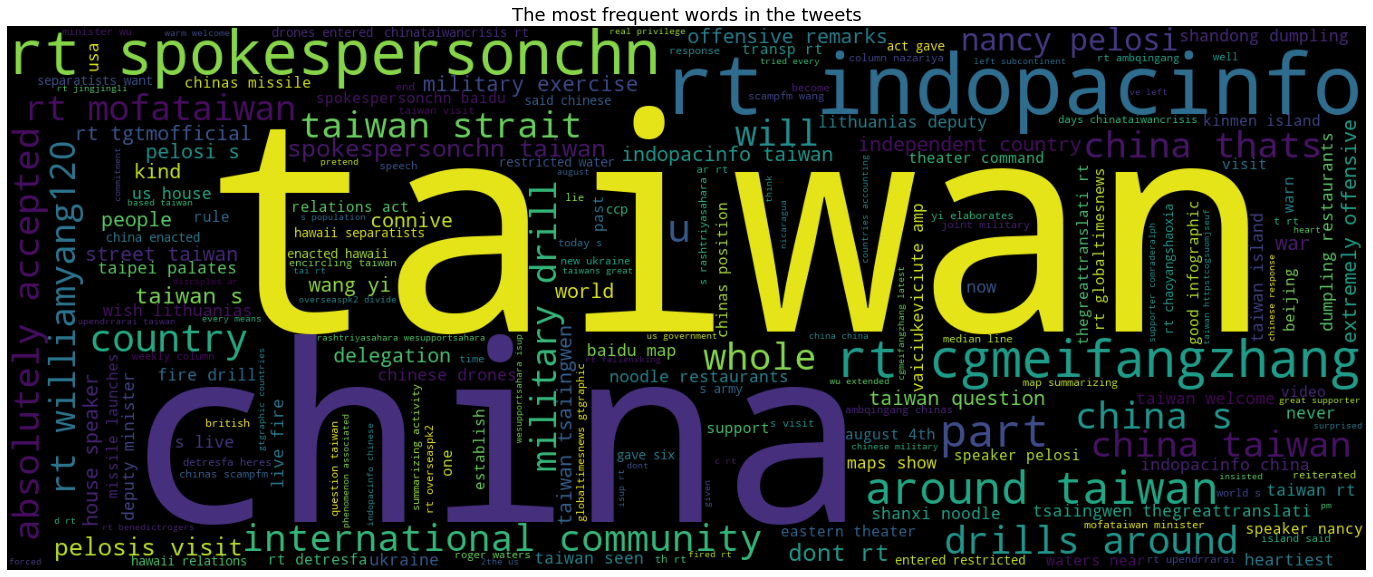

In [11]:
plt.figure(figsize=(30,10))
plt.imshow(WordCloud(width=1500,height=600,stopwords=STOPWORDS).generate(' '.join(tweets_df['full_text'].values)))
plt.axis('off')
plt.title("The most frequent words in the tweets",fontsize=18)
plt.show()

### Sentiment Analysis

#### Choose necessary columns

In [12]:
cleanTweet = tweets_df[["full_text", "polarity"]]
cleanTweet

,full_text,polarity
0,rt iameztoy extra random image i lets focus in...,-1.250000e-01
1,rt indopacinfo chinas media explains the milit...,-1.000000e-01
2,china even cut off communication they dont anw...,0.000000e+00
3,putin to xijinping i told you my friend taiwan...,1.000000e-01
4,rt chinauncensored i’m sorry i thought taiwan ...,-6.938894e-18
...,...,...
21992,rt indopacinfo a good infographic of chinas mi...,7.000000e-01
21993,rt indopacinfo a good infographic of chinas mi...,7.000000e-01
21994,reuters thanks pelosi smart move,2.071429e-01
21995,rt indopacinfo taiwan peoples desire for unifi...,5.000000e-02


#### Convert polarity into sentiment category

In [13]:
def convert(val):
    if val < 0:
        return "negative"
    elif val == 0:
        return "neutral"
    else:
        return "positive"
cleanTweet["score"] = cleanTweet["polarity"].apply(convert)
cleanTweet

,full_text,polarity,score
0,rt iameztoy extra random image i lets focus in...,-1.250000e-01,negative
1,rt indopacinfo chinas media explains the milit...,-1.000000e-01,negative
2,china even cut off communication they dont anw...,0.000000e+00,neutral
3,putin to xijinping i told you my friend taiwan...,1.000000e-01,positive
4,rt chinauncensored i’m sorry i thought taiwan ...,-6.938894e-18,negative
...,...,...,...
21992,rt indopacinfo a good infographic of chinas mi...,7.000000e-01,positive
21993,rt indopacinfo a good infographic of chinas mi...,7.000000e-01,positive
21994,reuters thanks pelosi smart move,2.071429e-01,positive
21995,rt indopacinfo taiwan peoples desire for unifi...,5.000000e-02,positive


#### Get value counts

In [14]:
sentiment = cleanTweet['score'].value_counts()
sentiment

neutral     8977
positive    8187
negative    4833
Name: score, dtype: int64

#### Drop neutral tweets

In [15]:
cleanTweet = cleanTweet[cleanTweet['score'] != 'neutral']
cleanTweet

,full_text,polarity,score
0,rt iameztoy extra random image i lets focus in...,-1.250000e-01,negative
1,rt indopacinfo chinas media explains the milit...,-1.000000e-01,negative
3,putin to xijinping i told you my friend taiwan...,1.000000e-01,positive
4,rt chinauncensored i’m sorry i thought taiwan ...,-6.938894e-18,negative
5,rt benedictrogers we must not let this happen ...,2.000000e-01,positive
...,...,...,...
21992,rt indopacinfo a good infographic of chinas mi...,7.000000e-01,positive
21993,rt indopacinfo a good infographic of chinas mi...,7.000000e-01,positive
21994,reuters thanks pelosi smart move,2.071429e-01,positive
21995,rt indopacinfo taiwan peoples desire for unifi...,5.000000e-02,positive


#### Map score

In [16]:
def mapscore(score):
    if score != "positive":
        return 0
    else:
        return 1
cleanTweet['scoremap'] = cleanTweet["score"].map(mapscore)
cleanTweet

,full_text,polarity,score,scoremap
0,rt iameztoy extra random image i lets focus in...,-1.250000e-01,negative,0
1,rt indopacinfo chinas media explains the milit...,-1.000000e-01,negative,0
3,putin to xijinping i told you my friend taiwan...,1.000000e-01,positive,1
4,rt chinauncensored i’m sorry i thought taiwan ...,-6.938894e-18,negative,0
5,rt benedictrogers we must not let this happen ...,2.000000e-01,positive,1
...,...,...,...,...
21992,rt indopacinfo a good infographic of chinas mi...,7.000000e-01,positive,1
21993,rt indopacinfo a good infographic of chinas mi...,7.000000e-01,positive,1
21994,reuters thanks pelosi smart move,2.071429e-01,positive,1
21995,rt indopacinfo taiwan peoples desire for unifi...,5.000000e-02,positive,1


In [17]:
(X, y) = cleanTweet['full_text'], cleanTweet['scoremap']
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit(X.values)


CountVectorizer(ngram_range=(1, 3))

In [18]:
X_trigram_vectorizer = trigram_vectorizer.transform(X.values)

#### Train and show scores

In [19]:
# X_test_to_save, y_test_to_save = None, None
# model_to_save = None
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    X_test_to_save, y_test_to_save = X_test, y_test

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    model_to_save = clf
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    print(f'{title}\n\nTrain score: {round(train_score, 2)} \nTest score: {round(test_score, 2)}\n')
    return clf, X_test, y_test

In [20]:
model_to_save, X_test_to_save, y_test_to_save = train_and_show_scores(X_trigram_vectorizer, y.values, 'Trigram Counts')

Trigram Counts

Train score: 1.0 
Test score: 0.94



#### SAVE TRAINED MODEL

In [21]:
import pickle
with open("../st_dashboard/model.pkl", 'wb') as f:
    pickle.dump(model_to_save, f)

# f = open("../st_dashboard/model.pkl", 'w')
# pickle.dump(model_to_save, f)

with open("../st_dashboard/X_test.pkl", 'wb') as f:
    pickle.dump(X_test_to_save, f)


with open("../st_dashboard/y_test.pkl", 'wb') as f:
    pickle.dump(y_test_to_save, f)